Calculate the distance posterior for GW170817.

In [1]:
%matplotlib inline

from matplotlib import pyplot as pl
import numpy as np

import readligo as rl

In [2]:
import lal
import lalsimulation

def fdwaveform(phiref, deltaF, m1, m2, fmin, dist, incl, fmax=0, fref=None):
    """
    A function to generate a frequency domain inspiral waveform. This function sets spin
    parameters to zero, so all output are non-spinning waveforms. The reference frequency is set to fmin.
    
    This function does not include the antenna patterns, so is detector and sky position
    independent.

    Args:
        phiref (float): the reference phase (rads)
        deltaF (float): the frequency bin size (Hz)
        m1 (float): the mass of the first component (solar masses)
        m2 (float): the mass of the second component (solar masses)
        fmin (float): the lower bound on frequency (Hz)
        dist (float): the source distance (in Mpc)
        incl (float): the source inclination angle (rads)
        fmax (float): maximum frequency for signal (Hz) (default of 0 computes signal up to ISCO for TaylorF2)
        fref (float): the reference frequency (Hz) (defaults to fmin)

    Returns:
        the plus and cross polarisation components of the signal in the frequency domain.
    """  

    approx = lalsimulation.IMRPhenomPv2
    #approx = lalsimulation.TaylorF2 # Taylor F2 approximant (you can change this to e.g. lalsimulation.IMRPhenomPv2)
    if fref is None:
        fref = fmin
 
    hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
        m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., dist*1e6*lal.PC_SI, incl,
        phiref, 0., 0., 0., deltaF, fmin, fmax, fref, None, approx)

    # return the frequency domain plus and cross waveforms
    return hptilde.data.data, hctilde.data.data

In [3]:
def antenna_response( gpsTime, ra, dec, psi, det ):
    """
    Get the response of a detector to plus and cross polarisation signals.
    
    Args:
        gpsTime (float): the GPS time of the observations
        ra (float): the right ascension of the source (rads)
        dec (float): the declination of the source (rads)
        psi (float): the polarisation angle of the source (rads)
        det (str): a detector name (e.g., 'H1' for the LIGO Hanford detector)
    
    Returns:
        The plus and cross response.
    """
    
    gps = lal.LIGOTimeGPS( gpsTime )
    gmst_rad = lal.GreenwichMeanSiderealTime(gps)

    # create detector-name map
    detMap = {'H1': lal.LALDetectorIndexLHODIFF,
              'L1': lal.LALDetectorIndexLLODIFF,
              'V1': lal.LALDetectorIndexVIRGODIFF,}

    try:
        detector=detMap[det]
    except KeyError:
        raise ValueError("ERROR. Key {} is not a valid detector name.".format(det))

    # get detector
    detval = lal.CachedDetectors[detector]

    response = detval.response

    # actual computation of antenna factors
    fp, fc = lal.ComputeDetAMResponse(response, ra, dec, psi, gmst_rad)

    return fp, fc

In [4]:
def loglikelihood(data, model, psd, deltaF):
    """
    The log likelihood function.
    
    Args:
        data (array): the complex frequency domain data
        model (array): the complex frequency domain model
        psd (array): the power spectral density estimate
        deltaF (float): the frequency step size
    """

    # get the difference between the data and the model
    diff = data - model
    
    # whiten this (divide by the ASD (sqrt of the PSD))
    diff /= np.sqrt(psd)

    # make sure any infinite values are zero'd (e.g. caused by ASD values that are zero)
    diff[~np.isfinite(diff)] = 0.

    # get the cross product (d-m)(d-m)*2
    chisq = np.vdot(diff, diff).real
    
    chisq *= 2*deltaF
    
    # the log likelihood function
    L = -chisq
    
    return L

In [5]:
# read in L1 data for GW170817

hdffiles = {'H1': '/local/scratch/LIGO/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5',
            'L1': '/local/scratch/LIGO/GW170817/L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5'}

det = 'L1'

strain, times, channeldic = rl.loaddata(hdffiles[det], tvec=True)

/local/environments/gw/gw-python/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [7]:
srate = 1./(times[1]-times[0])
print('Sample rate is {} Hz'.format(srate))

tpeak = 1842.43         # peak time of the signal
pidx = int(tpeak*srate) # index of peak of signal

Sample rate is 4096.0 Hz


In [30]:
# get 64 seconds of data up to (an arbitrary) 4 seconds after the peak
#dur = 64 # number of seconds of data to get
dur = 128
pads = 4

sigdata = strain[pidx-int((dur-pads)*srate):pidx+int(pads*srate)]

In [31]:
# get running median PSD
time = lal.LIGOTimeGPS(int(times[0]), 0) # set a GPS epoch for the time series (this can just be a "dummy" value)

length = len(strain)    # the number of samples in the time series data
nfft = int(dur*srate)   # number of time samples to use per FFT
stride = int(dur*srate) # the "stride" for the next FFT (dictates how many FFTs are averaged and overlap) 

deltaF = srate/nfft     # frequency step size
nbin = int((nfft/2)+1)  # number of frequency bins
deltaT = 1./srate # time step size

# put data into a time series object
data = lal.CreateREAL8TimeSeries("time data", time, 0.0, deltaT, lal.DimensionlessUnit, length)
for i in range(length):
    data.data.data[i] = strain[i] # put the data into the REAL8TimeSeries

# set the Tukey window
alpha = 2*srate*0.4/nfft
window = lal.CreateTukeyREAL8Window(nfft, alpha)

# create an "FFT plan"
FFTPlan = lal.CreateForwardREAL8FFTPlan(nfft, 1)

psdlalmedian = lal.CreateREAL8FrequencySeries("spectrum", time, 0.0, deltaF, lal.DimensionlessUnit, nbin)
# create the PSD using the median method
lal.REAL8AverageSpectrumMedian(psdlalmedian, data, nfft, stride, window, FFTPlan);

In [32]:
# create a signal model
ra = 3.446157844    # use fixed position of NGC4993
dec = -0.4080841591

# masses (use MAP masses from Prod-2 BBH fixed sky position run https://ldas-jobs.ligo.caltech.edu/~katerina.chatziioannou/O2/PE/G298048/ProductionRuns/Prod2/lalinferencenest/IMRPhenomPv2pseudoFourPN/128s/1187008882.45-0/V1H1L1/posplots.html)
# (maybe also try TalyorF2 run https://ldas-jobs.ligo-la.caltech.edu/~aaron.zimmerman/O2/G298048/Exp21_FixedSky/lalinferencenest/IMRPhenomPv2pseudoFourPN/128s/1187008882.45-0/V1H1L1/posplots.html)
m1 = 1.72140419742
m2 = 1.10859297829

distance = 44.6889906553

phiref = 2.60174675393
iota = 2.81558425046
psi = 0.860990548555
time = 1187008882.4294

fmin = 24
fref = 100
fmax = 400 # only compute signal up to 400 Hz

hplus, hcross = fdwaveform(phiref, deltaF, m1, m2, fmin, distance, iota, fmax=fmax, fref=fref)

Fp, Fx = antenna_response( times[0]+tpeak, ra, dec, psi, det )

sigmodel = hplus*Fp + hcross*Fx

# calculate at a range of phiref values
phis = np.arange(0., 2*np.pi, 2*np.pi/100)

# calculate signals model at a range of phis for a fixed distance
sigmodels = []
for phi in phis:
    hplus, hcross = fdwaveform(phi, deltaF, m1, m2, fmin, distance, iota, fmax=fmax, fref=fref)
    sigmodels.append(hplus*Fp + hcross*Fx)

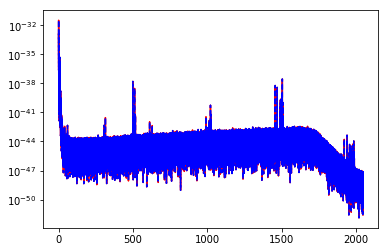

In [33]:
# window and FFT the data
# try LAL FFT
lalfft = lal.CreateCOMPLEX16FrequencySeries("spectrum", time, 0.0, deltaF, lal.DimensionlessUnit, nbin)

windata = lal.CreateREAL8TimeSeries("time data", time, 0.0, deltaT, lal.DimensionlessUnit, len(sigdata))
for i in range(len(sigdata)):
    windata.data.data[i] = window.data.data[i]*sigdata[i] # put the data into the REAL8TimeSeries

lal.REAL8TimeFreqFFT(lalfft, windata, FFTPlan);

# above should be the same as numpy's rfft (with the former being 1/srate smaller than the latter)
fdata = np.fft.rfft(window.data.data*sigdata)

freqs = np.fft.rfftfreq(nfft, d=1./srate)

# just compare FFTs as a sanity check
pl.semilogy(freqs, np.abs(fdata/srate)**2, 'r')
pl.semilogy(freqs, np.abs(lalfft.data.data)**2, 'b--')

In [34]:
# make signal, model and PSD the same length
minidx = int(fmin/deltaF)
maxidx = int(fmax/deltaF)

freqsc = freqs[minidx:maxidx]

fdatac = lalfft.data.data[minidx:maxidx]
sigmodelc = sigmodel[minidx:maxidx]
psdc = psdlalmedian.data.data[minidx:maxidx]

# get freq bins in signals calculated for each phi
for i in range(len(sigmodels)):
    sigmodels[i] = sigmodels[i][minidx:maxidx]

print(len(fdatac), len(psdc), len(sigmodelc))

48128 48128 48128


In [49]:
dists = np.linspace(10., 100., 100)

# calculate log likelihood over phi and distance
logL = np.zeros((len(phis), len(dists)))
for i in range(len(phis)):
    for j, dist in enumerate(dists):
        tmodel = sigmodels[i] * distance / dist

        #L = loglikelihood(fdatac, tmodel, psdc, deltaF)
        L = loglikelihood(fdatac, tmodel, psdc, deltaF)
        logL[i, j] = L + 2*np.log(dist) # include prior

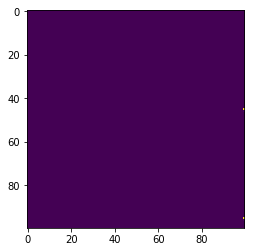

In [50]:
# show posterior
pl.imshow(np.exp(logL-np.max(logL.flatten())))

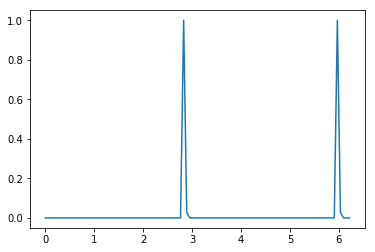

In [51]:
# plot phi posterior
post = np.exp(logL-np.max(logL.flatten()))
postphi = np.array([np.sum(p) for p in post])
pl.plot(phis, postphi)

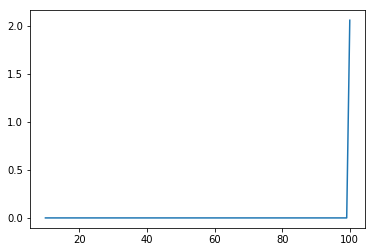

In [52]:
# plot distance posterior
postdist = np.array([np.sum(p) for p in post.T])
pl.plot(dists, postdist)

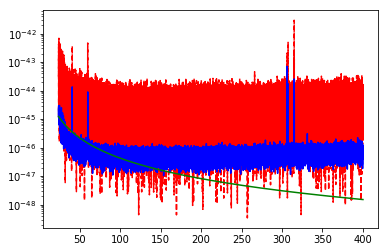

In [56]:
pl.semilogy(freqsc, np.abs(fdatac)**2, 'r--')
pl.semilogy(freqsc, psdc, 'b')
pl.semilogy(freqsc, np.abs(sigmodelc)**2, 'g')